# Constructing LIF neuron model with ``brainstate``

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/chaobrain/brain-modeling-ecosystem/blob/develop/docs/brainstate_LIF_neuron.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/chaobrain/brain-modeling-ecosystem/blob/develop/docs/brainstate_LIF_neuron.ipynb)

Welcome! This beginner-friendly tutorial will guide you through:

- Understanding the Leaky Integrate-and-Fire (LIF) neuron.
- Implementing LIF with `brainstate.nn.Dynamics`.
- Simulating with `brainstate.transform.for_loop`.
- Running small experiments (step response, tonic spiking, F–I curve).

Prerequisites:
- Basic Python. Some calculus intuition helps but is optional.
- `brainstate` and `brainunit` installed; this notebook uses unit-aware quantities (ms, mV, mA).

In [1]:
# Imports and environment setup
import brainstate
import brainunit as u
import jax
import numpy as np
import matplotlib.pyplot as plt

# Global simulation step (time resolution)
brainstate.environ.set(dt=0.1 * u.ms)

## LIF Basics

The LIF neuron approximates a neuron's membrane as a leaky RC circuit. Its membrane potential `V(t)` obeys:

- ODE: `dV/dt = (-(V - V_rest) + R I_in)/tau`
- Parameters:
  - `V_rest`: resting potential (e.g., 0 mV here for simplicity).
  - `R`: membrane resistance (maps input current to a steady-state voltage).
  - `tau`: membrane time constant (how fast `V` relaxes).
  - `I_in`: input current.

Spiking and reset:
- When `V` crosses a threshold `V_th`, the neuron emits a spike.
- After spiking, `V` is reset (commonly to `V_reset`).

Discrete-time integration:
- We integrate with an exponential Euler step (`brainstate.nn.exp_euler_step`),
  equivalent to the exact solution for this linear ODE over one small time step `dt`.
- For constant input, the steady state is `V_inf = V_rest + R I_in`, and
  `V(t + dt) = V_inf + (V(t) - V_inf) * exp(-dt/tau)`.

## Implementing LIF with `brainstate.nn.Dynamics`

We implement a single-compartment LIF neuron. 

In [2]:
from typing import Callable

class LIFDynamics(brainstate.nn.Dynamics):
    """
    A leaky integrate-and-fire neuron implemented as a Dynamics module.

    Parameters: R, tau, V_th, V_reset, V_rest, and a spike function.
    Soft reset subtracts (V_th - V_reset) when a spike occurs;
    Hard reset uses (V - V_reset), which resets exactly to V_reset.
    """
    def __init__(
        self,
        in_size: brainstate.typing.Size,
        R: brainstate.typing.ArrayLike = 1.0 * u.ohm,
        tau: brainstate.typing.ArrayLike = 5.0 * u.ms,
        V_th: brainstate.typing.ArrayLike = 1.0 * u.mV,
        V_reset: brainstate.typing.ArrayLike = 0.0 * u.mV,
        V_rest: brainstate.typing.ArrayLike = 0.0 * u.mV,
        V_initializer: Callable = brainstate.init.Constant(0.0 * u.mV),
        spk_fun: Callable = brainstate.surrogate.ReluGrad(),
        spk_reset: str = "soft",
        name: str | None = None,
    ):
        super().__init__(in_size, name=name)
        # Parameters (unit-aware)
        self.R = brainstate.init.param(R, self.varshape)
        self.tau = brainstate.init.param(tau, self.varshape)
        self.V_th = brainstate.init.param(V_th, self.varshape)
        self.V_reset = brainstate.init.param(V_reset, self.varshape)
        self.V_rest = brainstate.init.param(V_rest, self.varshape)
        self.V_initializer = V_initializer
        # Spiking
        self.spk_fun = spk_fun
        self.spk_reset = spk_reset

    def init_state(self, batch_size: int | None = None, **kwargs):
        self.V = brainstate.HiddenState(
            brainstate.init.param(self.V_initializer, self.varshape, batch_size)
        )

    def reset_state(self, batch_size: int | None = None, **kwargs):
        self.V.value = brainstate.init.param(self.V_initializer, self.varshape, batch_size)

    def get_spike(self, V=None):
        V = self.V.value if V is None else V
        v_scaled = (V - self.V_th) / (self.V_th - self.V_reset)
        return self.spk_fun(v_scaled)

    def update(self, x=0.0 * u.mA):
        last_v = self.V.value
        spk = self.get_spike(last_v)
        # Reset policy
        V_th_or_v = self.V_th if self.spk_reset == 'soft' else jax.lax.stop_gradient(last_v)
        V = last_v - (V_th_or_v - self.V_reset) * spk
        # Dynamics integration by exponential Euler
        dv = lambda v: (-(v - self.V_rest) + self.R * x) / self.tau
        V = brainstate.nn.exp_euler_step(dv, V)
        self.V.value = V
        return self.get_spike(V)

# Create and initialize a neuron
lif = LIFDynamics(1)
brainstate.nn.init_all_states(lif)
lif

LIFDynamics(
  in_size=(1,),
  out_size=(1,),
  R=1. * ohm,
  tau=5. * msecond,
  V_th=1. * mvolt,
  V_reset=0. * mvolt,
  V_rest=0. * mvolt,
  V_initializer=Constant(
    value=0. * mvolt
  ),
  spk_fun=ReluGrad(alpha=0.3, width=1.0),
  spk_reset=soft,
  V=HiddenState(
    value=float32[1] * mvolt
  )
)

### Code Walkthrough
- Parameters are registered with `brainstate.init.param` to track shapes and units.
- Hidden state `V` holds the membrane potential and updates each step.
- `get_spike(V)`: rescales `(V - V_th)` by `(V_th - V_reset)` and applies a surrogate spike function (here `ReluGrad`), enabling differentiable spikes for learning.
- Reset: `soft` subtracts `(V_th - V_reset) * spk`; `hard` subtracts `(V - V_reset) * spk` (i.e., set to `V_reset` when spiking).
- Integration: `exp_euler_step` advances `V` one `dt` under the environment's time step.

## Simulating with `brainstate.transform.for_loop`

We'll write a small helper to run the neuron over a sequence of input currents,
use indexing pattern with `brainstate.environ.context(i=i)`.

In [3]:
def run_lif(lif_module, inputs):
    """Run the LIF over a 1D array of input currents.
    Returns membrane potentials and spikes over time.
    """
    lif_module.reset_state()
    idx = np.arange(len(inputs))

    def step(i, x):
        with brainstate.environ.context(i=i):
            s = lif_module(x)
            return lif_module.V.value, s

    V_seq, S_seq = brainstate.transform.for_loop(step, idx, inputs)
    return V_seq, S_seq

dt = brainstate.environ.get_dt()
dt

0.1 * msecond

## Experiment 1: Subthreshold Step Response

Use a constant current that keeps `V_inf = V_rest + R I` below `V_th`. We should see a smooth approach to `V_inf` without spiking.

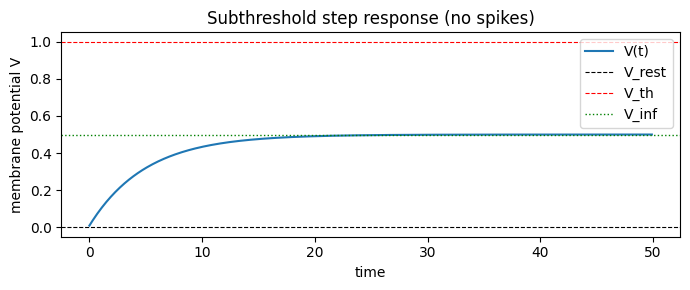

In [4]:
n_time = 500
I_sub = 0.5 * u.mA  # V_inf = 0.5 mV < V_th = 1.0 mV
inputs = np.ones(n_time) * I_sub
V_sub, S_sub = run_lif(lif, inputs)
t = np.arange(n_time) * dt

plt.figure(figsize=(7, 3))
plt.plot(t, V_sub, label='V(t)')
plt.axhline(0.0 * u.mV, ls='--', c='k', lw=0.8, label='V_rest')
plt.axhline(1.0 * u.mV, ls='--', c='r', lw=0.8, label='V_th')
plt.axhline(0.5 * u.mV, ls=':', c='g', lw=1.0, label='V_inf')
plt.title('Subthreshold step response (no spikes)')
plt.xlabel('time')
plt.ylabel('membrane potential V')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Experiment 2: Suprathreshold Constant Current (Tonic Spiking)

Now choose a current with `V_inf > V_th`. The neuron should emit regular spikes.
We'll also estimate the firing rate from the simulated spikes.

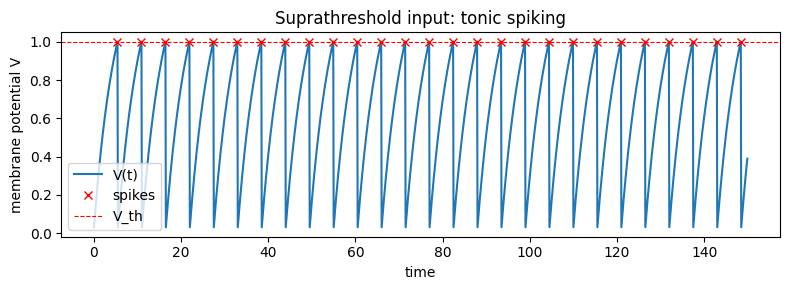

Mean ISI: 5.5 * msecond
Estimated firing rate: 181.81819 * hertz


In [10]:
n_time = 1500
I_sup = 1.5 * u.mA  # V_inf = 1.5 mV > V_th
inputs = np.ones(n_time) * I_sup
V_sup, S_sup = run_lif(lif, inputs)
t = np.arange(n_time) * dt

# Basic spike detection from surrogate output (>= 0.5 as spike)
# spk_mask = np.asarray(S_sup) >= 0.5
spk_time, spk_indices = np.where(spk_mask)
spike_times = t[spk_time]

plt.figure(figsize=(8, 3))
plt.plot(t, V_sup, label='V(t)')
plt.plot(spike_times, V_sup[spk_time], 'rx', label='spikes')
plt.axhline(1.0 * u.mV, ls='--', c='r', lw=0.8, label='V_th')
plt.title('Suprathreshold input: tonic spiking')
plt.xlabel('time')
plt.ylabel('membrane potential V')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Estimate firing rate from inter-spike intervals (ISI)
if spike_times.size > 1:
    isi = u.math.diff(spike_times)
    mean_isi = u.math.mean(isi)
    firing_rate = (1.0 / mean_isi).to(u.Hz)
    print('Mean ISI:', mean_isi)
    print('Estimated firing rate:', firing_rate)
else:
    print('No spikes detected — increase I_sup or duration.')

## Experiment 3: Soft vs Hard Reset

`soft` decreases `V` by `(V_th - V_reset)`; `hard` resets directly to `V_reset`.
Below we run both with the same current to compare trajectories.

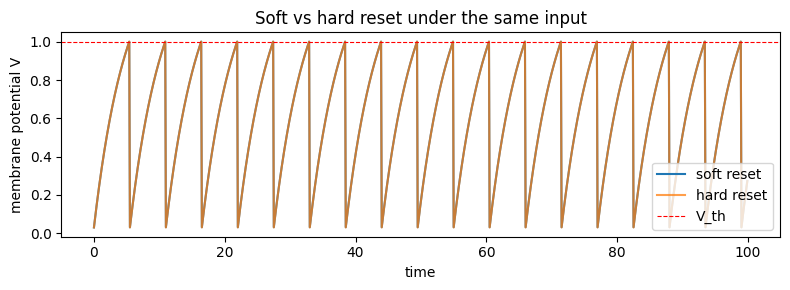

In [6]:
lif_soft = LIFDynamics(1, spk_reset='soft')
lif_hard = LIFDynamics(1, spk_reset='hard')
brainstate.nn.init_all_states(lif_soft)
brainstate.nn.init_all_states(lif_hard)

n_time = 1000
inputs = np.ones(n_time) * (1.5 * u.mA)
V_soft, _ = run_lif(lif_soft, inputs)
V_hard, _ = run_lif(lif_hard, inputs)
t = np.arange(n_time) * dt

plt.figure(figsize=(8, 3))
plt.plot(t, V_soft, label='soft reset')
plt.plot(t, V_hard, label='hard reset', alpha=0.75)
plt.axhline(1.0 * u.mV, ls='--', c='r', lw=0.8, label='V_th')
plt.title('Soft vs hard reset under the same input')
plt.xlabel('time')
plt.ylabel('membrane potential V')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Experiment 4: F–I Curve (Firing Rate vs Current)

We sweep constant inputs and estimate the stationary firing rate at each level.
This is a classic characterization for LIF neurons.

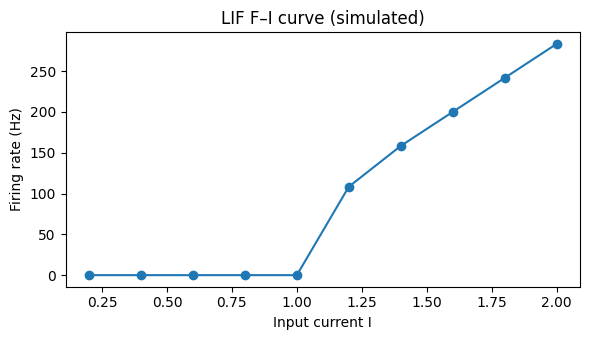

In [11]:
lif_fi = LIFDynamics(1)
brainstate.nn.init_all_states(lif_fi)

def estimate_rate(I_const, n_burn=300, n_eval=1200):
    # Simulate, drop initial transients (burn), then count spikes
    n_time = n_burn + n_eval
    inputs = np.ones(n_time) * I_const
    V, S = run_lif(lif_fi, inputs)
    spk = np.asarray(S[n_burn:]) >= 0.5
    n_spikes = spk.sum()
    T = n_eval * brainstate.environ.get_dt()
    rate = (n_spikes / (T / u.second)) * u.Hz
    return rate

curr_levels = np.linspace(0.2, 2.0, 10) * u.mA
rates = u.math.asarray([estimate_rate(I) for I in curr_levels])

plt.figure(figsize=(6, 3.5))
plt.plot(curr_levels, rates, 'o-')
plt.xlabel('Input current I')
plt.ylabel('Firing rate (Hz)')
plt.title('LIF F–I curve (simulated)')
plt.tight_layout()
plt.show()

## Tips and Common Pitfalls
- Units matter: keep `R`, `tau`, `V_*`, and `I` consistent. `brainunit` helps track them.
- Time step `dt`: too large can distort dynamics or miss spikes; start with `0.1 ms`.
- Always re-initialize or reset states before a new run (`init_all_states` once, `reset_state` per run).
- Surrogate spikes are differentiable; when just simulating, treat values `>= 0.5` as spikes.
- Soft vs hard reset changes spike waveform and ISI slightly; both are common in literature.

## Where To Go Next
- Add synaptic inputs and build small networks (`brainstate.nn` projections).
- Explore noise currents and refractory periods.
- Compare with conductance-based models (e.g., Hodgkin–Huxley) in the docs.